# Setup

In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()
# mpld3.disable_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import torch
torch.__version__

'1.1.0'

In [78]:
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import models

In [79]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [80]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import albumentations

In [23]:
matplotlib.__version__, albumentations.__version__

('3.0.3', '0.2.3')

# Train Models

In [24]:
import pandas as pd
from sklearn.model_selection import GroupKFold, KFold
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import albumentations as albu

from am.segment.dataset import AMDataset, make_image_mask_dfs, load_ds, \
    train_transform, valid_transform, default_transform
from am.segment.loss import jaccard, CombinedLoss
from am.segment.model import UNet11, AlbuNet, UNet16
from am.segment.train import train_loop
from am.segment.utils import plot_images_row
from am.utils import plot_overlay

In [25]:
# train_ds.transform = valid_transform()

In [26]:
# Second stage pseudo labeling

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/microscopy/20171106_Hepa_Nov_ANALYSIS_PAPER_pseudo_tiles'))

# # cv = GroupKFold(n_splits=2)
# # train_inds, valid_inds = next(cv.split(image_df, groups=image_df.group))

# # cv = KFold(n_splits=2, shuffle=True)
# # train_inds, valid_inds = next(cv.split(image_df))

# train_ds = AMDataset(image_df, mask_df,
#                      transform=train_transform())

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/tiles/20171106_Hepa_Nov_ANALYSIS_PAPER'))

# valid_ds = AMDataset(image_df[image_df.group == 'FLi2'], mask_df[mask_df.group == 'FT1'],
#                      transform=valid_transform())
# len(train_ds), len(valid_ds)

In [27]:
# DAN GroupKFold validation

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/microscopy/20171106_Hepa_Nov_ANALYSIS_PAPER_pseudo_tiles'))
# image_df.shape, mask_df.shape

# # cv = GroupKFold(n_splits=2)
# # train_inds, valid_inds = next(cv.split(image_df, groups=image_df.group))

# valid_groups = ['F1', 'FLi2']
# train_inds = image_df[~image_df.group.isin(valid_groups)].index.values
# valid_inds = image_df[image_df.group.isin(valid_groups)].index.values

# n = len(train_inds) // 2
# rand_inds = np.random.choice(train_inds, n, replace=False)
# train_ds = AMDataset(image_df.iloc[rand_inds], mask_df.iloc[rand_inds],
#                      transform=train_transform())

# n = len(valid_inds) // 2
# rand_inds = np.random.choice(valid_inds, n, replace=False)
# valid_ds = AMDataset(image_df.iloc[rand_inds], mask_df.iloc[rand_inds],
#                      transform=valid_transform())
# len(train_ds), len(valid_ds)

In [28]:
# Train on DAN validate on DHB

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/microscopy/20171106_Hepa_Nov_ANALYSIS_PAPER_pseudo_tiles'))
# train_ds = AMDataset(image_df, mask_df,
#                      transform=train_transform())

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/tiles/20180514_Coculture_PAPER'))
# valid_ds = AMDataset(image_df, mask_df,
#                      transform=valid_transform())
# len(train_ds), len(valid_ds)

In [29]:
# Test set predictions

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/microscopy/20171106_Hepa_Nov_ANALYSIS_PAPER_pseudo_tiles'))

# train_ds = AMDataset(image_df, mask_df,
#                      transform=train_transform())

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/tiles/20171106_Hepa_Nov_ANALYSIS_PAPER'))
# valid_ds = AMDataset(image_df[image_df.group == 'FB4'], mask_df[mask_df.group == 'FB4'],
#                      transform=valid_transform())
# len(train_ds), len(valid_ds)

In [30]:
# DHB GroupKFold validation

# image_df, mask_df = make_image_mask_dfs(
#     Path('data/tiles/20180514_Coculture_PAPER'))

# cv = GroupKFold(n_splits=2)
# train_inds, valid_inds = next(cv.split(image_df, groups=image_df.group))

# train_ds = AMDataset(image_df.iloc[train_inds], mask_df.iloc[train_inds],
#                      transform=train_transform())

# valid_ds = AMDataset(image_df.iloc[valid_inds], mask_df.iloc[valid_inds],
#                      transform=valid_transform())
# len(train_ds), len(valid_ds)

In [31]:
# import mlflow
# mlflow.set_experiment('optimize network arch and other hyperparameters')

In [32]:
# import cv2
# from am_segm.utils import read_image

In [33]:
# image = read_image('data/Crops of Exp9_P/source/well1/source.tif')
# image.shape

In [61]:
train_ds = load_ds('data/DAN_AMs_6Aug2019/manual_tiles',
                   train_transform(), [], size=18)
# train_ds += load_ds('data/DHB_ds2/manual_tiles',
#                    train_transform(), [], size=18)
# train_ds += load_ds('data/DHB_ds2/pseudo_tiles',
#                     train_transform())
valid_ds = load_ds('data/DAN_AMs_6Aug2019/source_tiles',
                   transform=valid_transform(), groups=['1-real_well_8-P'], size=None)
len(train_ds), len(valid_ds)

(18, 225)

In [62]:
# inds = np.random.choice(valid_ds.image_df.shape[0], 12, replace=False)
# valid_ds.image_df.iloc[inds]

In [63]:
train_ds.image_df.group.unique(), valid_ds.image_df.group.unique()

(array(['2-real_well_7-F'], dtype=object),
 array(['1-real_well_8-P'], dtype=object))

In [64]:
for (image, mask) in valid_ds:
    break
print(image.shape, mask.shape)
print(image.max(), mask.max())

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
tensor(1.6117) tensor(0.)


In [65]:
# plot_images_row([image, mask]);

Train data


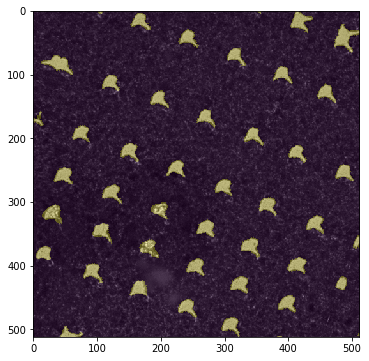

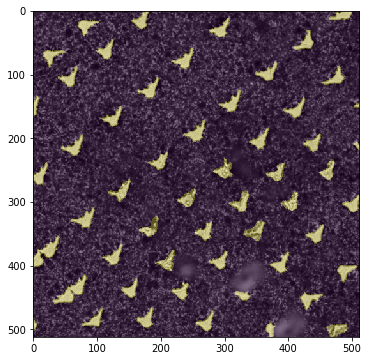

Valid data


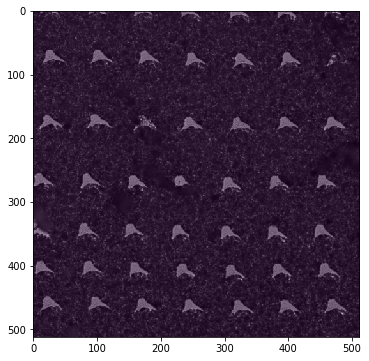

In [66]:
print('Train data')
n = 2
rinds = np.random.randint(0, len(train_ds), n)
for i in rinds:
    img, mask = train_ds[i]
#     img_no_tfm, _ = train_no_tfm_ds[i]
    fig = plot_overlay(img, mask, figsize=(6, 6))
#     fig = plot_images_row([img_no_tfm, img])
    plt.show()
#     if i == n - 1: break
    
print('Valid data')
n = 3
for i, (img, mask) in enumerate(valid_ds):
    plot_overlay(img, mask, figsize=(6, 6))
    plt.show()
    if i == n - 1: break

In [39]:
# batch_size = 12
batch_size = 4
train_dl = DataLoader(
    dataset=train_ds,
    shuffle=True,
    num_workers=4,
    batch_size=batch_size,
    pin_memory=torch.cuda.is_available()
)
if valid_ds:
    valid_dl = DataLoader(
        dataset=valid_ds,
        shuffle=True,
        num_workers=4,
        batch_size=batch_size,
        pin_memory=torch.cuda.is_available()
    )
else:
    valid_dl = None
len(train_dl), len(valid_dl) if valid_dl else 0

(5, 57)

In [40]:
# for (input, target), (_, row) in zip(train_ds, train_ds.image_df.iterrows()):
#     print(row.path, input.shape, target.shape)

In [41]:
# target.min(), target.max()

In [42]:
# lr = 1e-4
# n_epochs = 15

# # log_dir = 'runs/vgg16-jacc0.5'
# # writer = SummaryWriter(log_dir, flush_secs=1)
# writer = None

# # model = AlbuNet(pretrained=True)
# model = UNet16(pretrained=True)

# optimizer = Adam(model.parameters(), lr=lr)
# criterion = LossBinary(jaccard_weight=0.5)

# train_loop(model, train_dl, valid_dl,
#            optimizer, criterion,
#            n_epochs, writer)

In [43]:
import segmentation_models_pytorch as smp

# log_dir = 'runs/smp-se_resnext50_32x4d-jacc05'
# writer = SummaryWriter(log_dir, flush_secs=1)
# writer = None

# n_epochs = 10
# lr_enc = 1e-4
# lr_dec = 3e-4

n_epochs = 10
lr_enc = 3e-4
lr_dec = 1e-3

model = smp.Unet(encoder_name='se_resnext50_32x4d', decoder_use_batchnorm=True)
# model = smp.Unet(encoder_name='resnet50', decoder_use_batchnorm=True)

optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': lr_enc},
    {'params': model.decoder.parameters(), 'lr': lr_dec},
])
criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

train_loop(
    model, train_dl, valid_dl, optimizer, criterion, n_epochs
)

Epoch 1/10
----------
.....
Train loss: 1.33276, train metric: 0.23721
.........................................................
Valid loss: 2.34753, valid metric: 0.17460
0 min 11 sec
Epoch 2/10
----------
.....
Train loss: 0.31810, train metric: 0.69617
.........................................................
Valid loss: 3.63236, valid metric: 0.22603
0 min 15 sec
Epoch 3/10
----------
.....
Train loss: 0.20210, train metric: 0.78921
.........................................................
Valid loss: 2.33153, valid metric: 0.19043
0 min 20 sec
Epoch 4/10
----------
.....
Train loss: 0.17212, train metric: 0.80506
.........................................................
Valid loss: 1.87427, valid metric: 0.14102
0 min 25 sec
Epoch 5/10
----------
.....
Train loss: 0.14795, train metric: 0.82517
.........................................................
Valid loss: 1.84149, valid metric: 0.12771
0 min 30 sec
Epoch 6/10
----------
.....
Train loss: 0.13993, train metric: 0.82719
....

In [76]:
optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters(), 'lr': lr_enc/3},
    {'params': model.decoder.parameters(), 'lr': lr_dec/3},
])
criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

train_loop(model, train_dl, valid_dl,
           optimizer, criterion, n_epochs=10)

Epoch 1/10
----------
.........
Train loss: 0.25170, train metric: 0.65652
.........................................................
Valid loss: 0.20631, valid metric: 0.72812
0 min 5 sec
Epoch 2/10
----------
.........
Train loss: 0.23224, train metric: 0.67340
.........................................................
Valid loss: 0.15589, valid metric: 0.78112
0 min 11 sec
Epoch 3/10
----------
.........
Train loss: 0.26770, train metric: 0.67223
.........................................................
Valid loss: 0.22080, valid metric: 0.68063
0 min 17 sec
Epoch 4/10
----------
.........
Train loss: 0.22678, train metric: 0.70759
.........................................................
Valid loss: 0.16201, valid metric: 0.77186
0 min 23 sec
Epoch 5/10
----------
.........
Train loss: 0.20990, train metric: 0.72383
.........................................................
Valid loss: 0.16437, valid metric: 0.75762
0 min 28 sec
Epoch 6/10
----------
.........
Train loss: 0.20224, tra

In [77]:
# optimizer = torch.optim.Adam([
#     {'params': model.encoder.parameters(), 'lr': lr_enc/9},
#     {'params': model.decoder.parameters(), 'lr': lr_dec/9},
# ])
# criterion = CombinedLoss(bce_weight=0.5, jaccard=True, smooth=1e-15)

# train_loop(model, train_dl, valid_dl,
#            optimizer, criterion,
#            n_epochs=10)

In [44]:
model_path = 'model/unet-dan.pt'
torch.save(model.state_dict(), model_path)

In [53]:
# l = list(list(model.children())[0].children())[0][0]

In [54]:
# t = list(l.parameters())[0]

In [55]:
# t.data.dtype

In [56]:
# import segmentation_models_pytorch as smp

# n_epochs = 10
# lr_dec = 1e-4

# # log_dir = 'runs/smp-se_resnext50_32x4d-jacc05'
# # writer = SummaryWriter(log_dir, flush_secs=1)
# writer = None

# model = smp.Unet(encoder_name='se_resnext50_32x4d', decoder_use_batchnorm=True)

# optimizer = torch.optim.Adam([
#     {'params': model.decoder.parameters(), 'lr': lr_dec}, 
# ])
# criterion = LossBinary(jaccard_weight=0.5)

# train_loop(model, train_dl, valid_dl,
#            optimizer, criterion,
#            n_epochs, writer)

# n_epochs = 10
# lr_enc = 1e-4
# lr_dec = 1e-4

# optimizer = torch.optim.Adam([
#     {'params': model.encoder.parameters(), 'lr': lr_enc},
#     {'params': model.decoder.parameters(), 'lr': lr_dec}, 
# ])

# train_loop(model, train_dl, valid_dl,
#            optimizer, criterion,
#            n_epochs, writer)

In [57]:
# import segmentation_models_pytorch as smp

# n_epochs = 5
# lr_dec = 3e-4

# # log_dir = 'runs/smp-se_resnet50-jacc05'
# # writer = SummaryWriter(log_dir, flush_secs=1)
# writer = None

# model = smp.Unet(encoder_name='se_resnet50', decoder_use_batchnorm=True)

# optimizer = torch.optim.Adam([
#     {'params': model.decoder.parameters(), 'lr': lr_dec}, 
# ])
# criterion = LossBinary(jaccard_weight=0.5)

# train_loop(model, train_dl, valid_dl,
#            optimizer, criterion,
#            n_epochs, writer)

In [58]:
# import segmentation_models_pytorch as smp

# n_epochs = 10
# lr_enc = 1e-4
# lr_dec = 1e-4

# # log_dir = 'runs/smp-se_resnet50-jacc05'
# # writer = SummaryWriter(log_dir, flush_secs=1)
# writer = None

# # model = smp.Unet(encoder_name='se_resnet50', decoder_use_batchnorm=True)

# optimizer = torch.optim.Adam([
#     {'params': model.encoder.parameters(), 'lr': lr_enc},
#     {'params': model.decoder.parameters(), 'lr': lr_dec}, 
# ])
# criterion = LossBinary(jaccard_weight=0.5)

# train_loop(model, train_dl, valid_dl,
#            optimizer, criterion,
#            n_epochs, writer)

# Prediction

In [45]:
from am.utils import load_model

In [46]:
model = load_model(model_path)

In [47]:
from am.segment.utils import convert_to_image, plot_images_row

def predict_plot(model, inputs, targets):
    targets_pred = torch.sigmoid(model(inputs.to('cuda')))
    
    n = min(len(inputs), len(targets))
    for i in range(n):
        plot_images_row([
            convert_to_image(targets[i]),
            convert_to_image(inputs[i]),
#             convert_to_image(targets_pred[i]),
#             (np.sqrt(convert_to_image(targets_pred[i])) > 0.5).astype(int),
            (convert_to_image(targets_pred[i]) > 0.5).astype(int)
        ], titles=['Labels', 'Inputs', 'Predicted', 'Pred mask'])

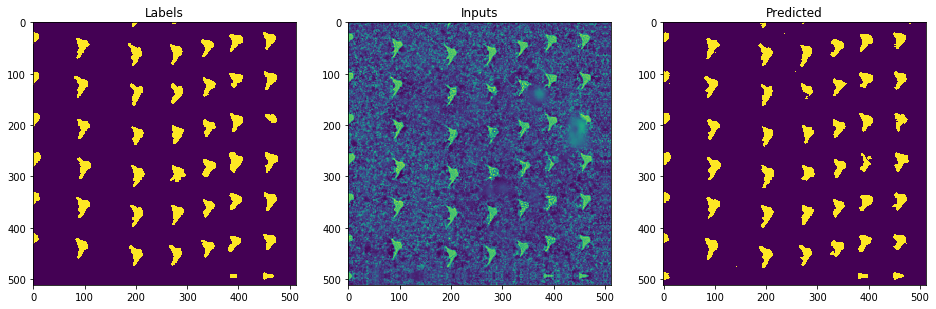

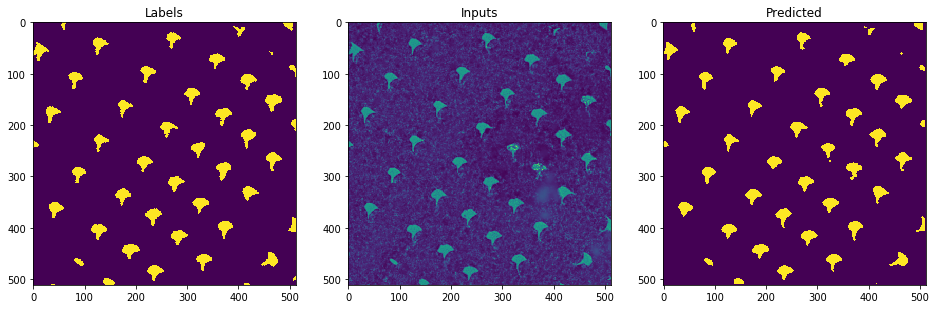

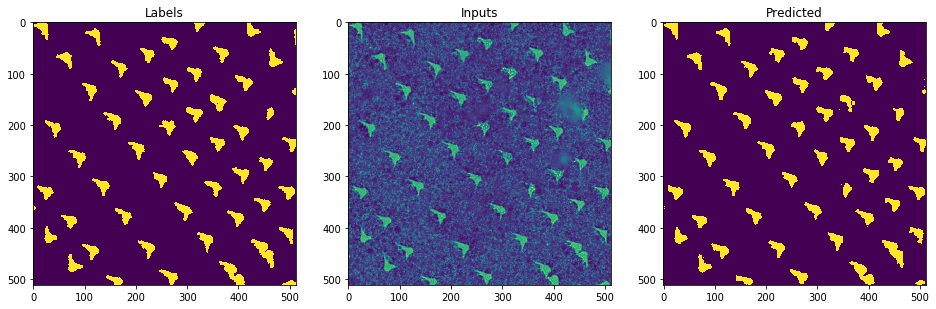

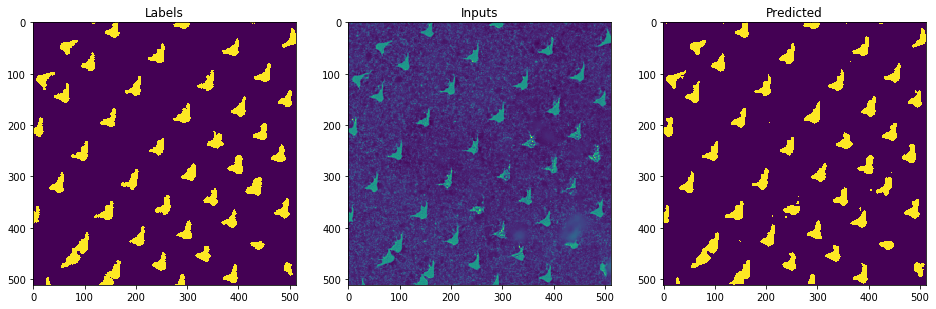

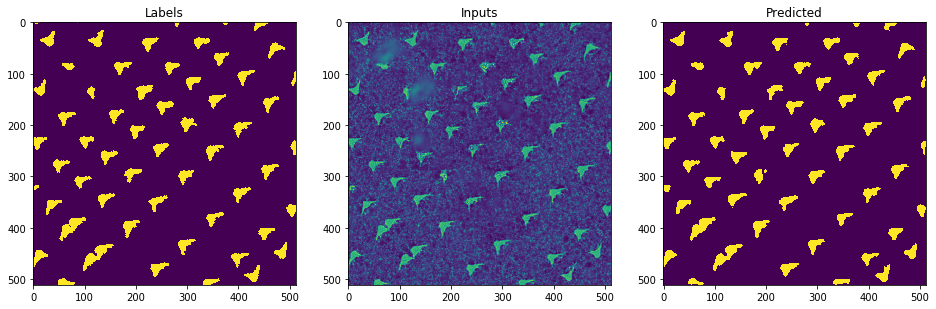

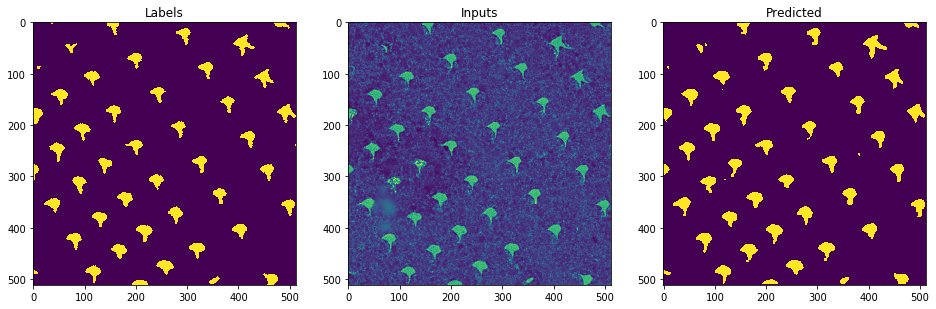

In [50]:
n = 2
for i, (inputs, targets) in enumerate(train_dl):
    predict_plot(model, inputs, targets)
    if i == n-1: break

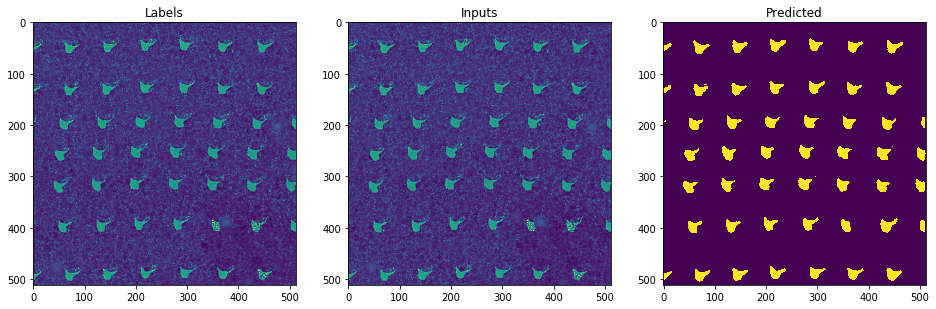

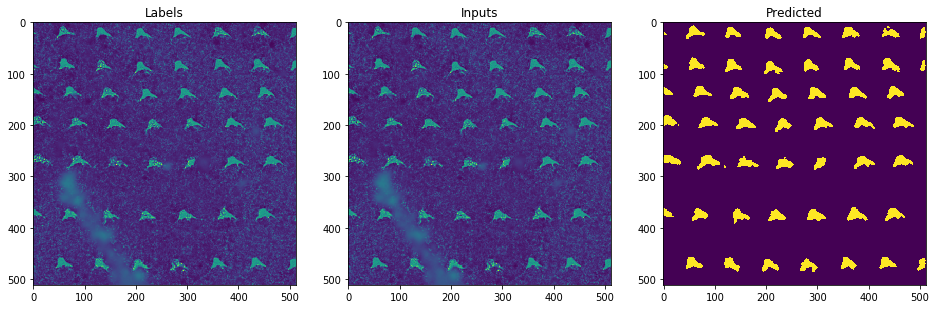

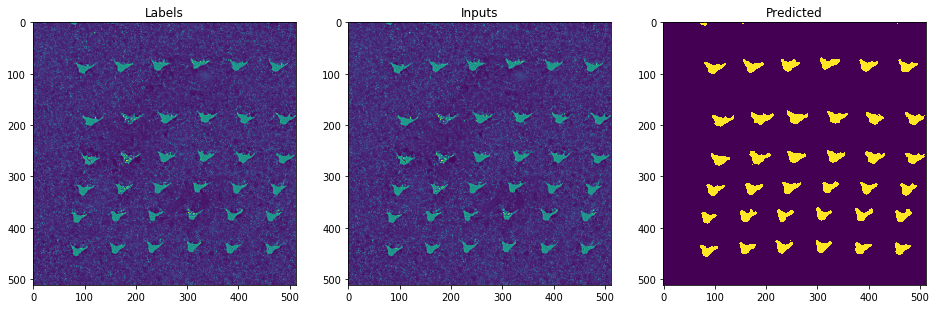

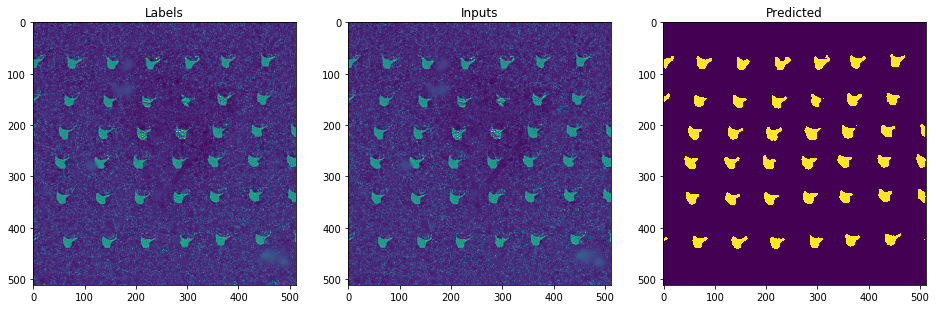

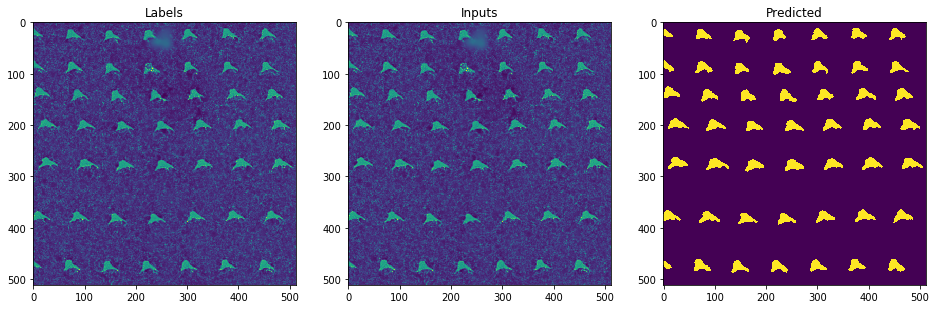

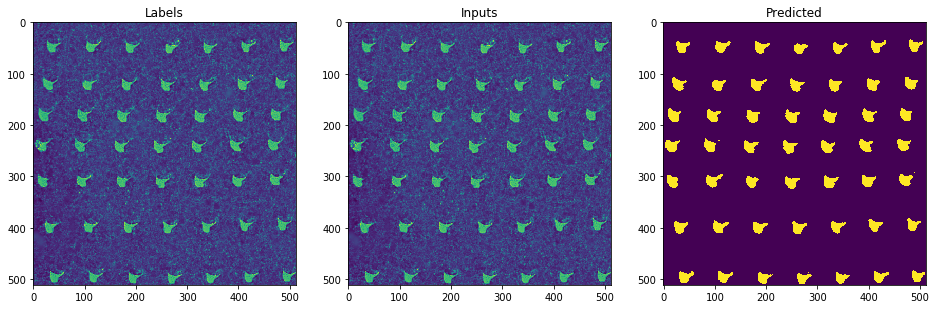

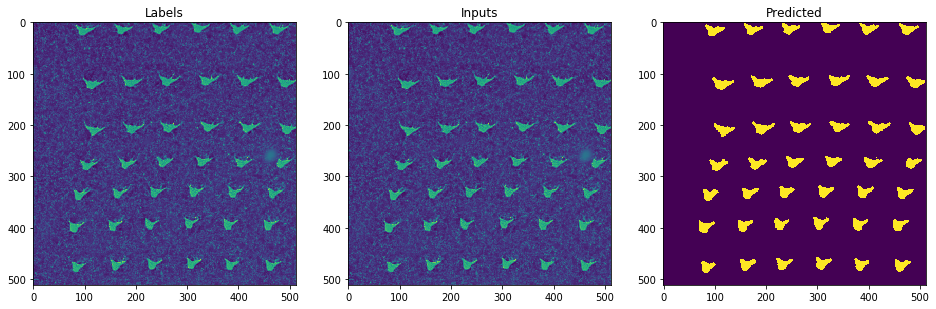

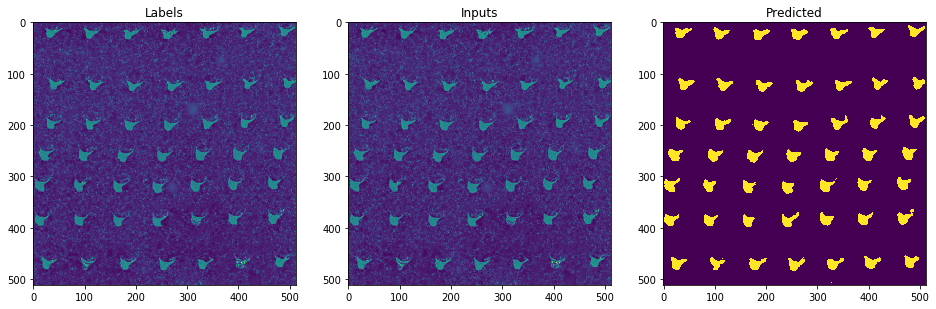

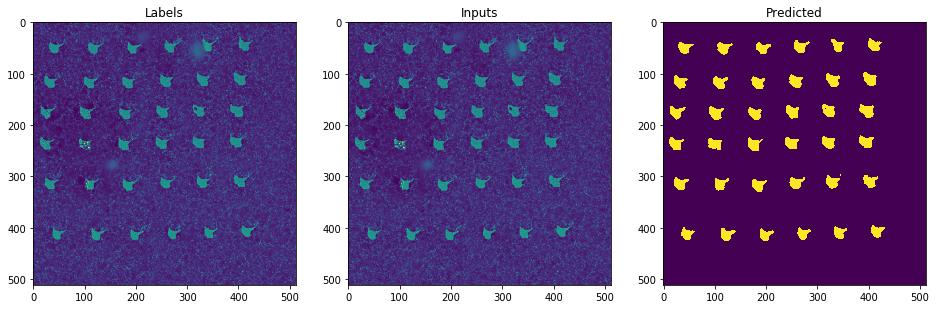

In [67]:
n = 3
for i, (inputs, targets) in enumerate(valid_dl):
    predict_plot(model, inputs, targets)
    if i == n - 1: break

# Save Predictions

In [84]:
import json
from shutil import copy, rmtree
from am.utils import read_image, save_overlay
from am.segment.predict import predict_save
from am.segment.preprocess import stitch_tiles_at_path

In [69]:
# !cp -r data/DHB_ds1/source_tiles data/DHB_ds1/pseudo_tiles

In [70]:
# pred_path = Path('data/20171106_Hepa_Nov_ANALYSIS_PAPER/pseudo_tiles')
# pred_path = Path('data/20180514_Coculture_PAPER/pseudo_tiles')
# pred_path = Path('data/Crops of mouse 7-8/pseudo_tiles')
# pred_path = Path('data/Crops of Exp9_P/pseudo_tiles')
ds_path = Path('data/DAN_AMs_6Aug2019')
ds = load_ds(ds_path / 'source_tiles', valid_transform())
predict_save(model, ds, pred_path=ds_path / 'pseudo_tiles')

3-real_well_6-Processed
5-real_well_4-F
7-real_well-2-F
1-real_well_8-P
6-real_well_3-P
2-real_well_7-F
3-real_well_6-P
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/000.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/000.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/001.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/001.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/002.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/002.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/003.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/003.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/004.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/004.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/005.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/005.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/006.png
data/DAN_AMs_6Aug2019/pseudo_tiles

data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/076.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/077.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/077.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/078.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/078.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/079.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/079.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/080.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/080.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/081.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/081.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/082.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/082.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/083.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/083.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/154.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/154.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/155.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/155.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/156.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/156.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/157.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/157.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/158.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/158.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/159.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/159.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/160.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/mask/160.png
data/DAN_AMs_6Aug2019/pseudo_tiles/3-real_well_6-P/source/161.png
data/DAN_AMs_6Aug2019/ps

data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/006.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/006.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/007.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/007.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/008.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/008.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/009.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/009.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/010.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/010.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/011.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/011.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/012.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/012.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/013.png
data/DAN_AMs_6Aug2019/ps

data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/083.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/084.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/084.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/085.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/085.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/086.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/086.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/087.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/087.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/088.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/088.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/089.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/089.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/090.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/090.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/161.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/162.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/162.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/163.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/163.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/164.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/164.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/165.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/165.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/166.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/166.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/167.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/167.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/source/168.png
data/DAN_AMs_6Aug2019/pseudo_tiles/5-real_well_4-F/mask/168.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/014.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/014.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/015.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/015.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/016.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/016.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/017.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/017.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/018.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/018.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/019.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/019.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/020.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/020.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/021.png
data/DAN_AMs_6Aug2019/ps

data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/091.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/092.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/092.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/093.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/093.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/094.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/094.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/095.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/095.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/096.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/096.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/097.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/097.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/098.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/098.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/169.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/170.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/170.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/171.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/171.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/172.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/172.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/173.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/173.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/174.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/174.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/175.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/175.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/source/176.png
data/DAN_AMs_6Aug2019/pseudo_tiles/7-real_well-2-F/mask/176.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/022.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/023.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/023.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/024.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/024.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/025.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/025.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/026.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/026.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/027.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/027.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/028.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/028.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/029.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/029.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/100.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/101.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/101.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/102.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/102.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/103.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/103.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/104.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/104.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/105.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/105.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/106.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/106.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/107.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/107.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/178.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/179.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/179.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/180.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/180.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/181.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/181.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/182.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/182.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/183.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/183.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/184.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/184.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/source/185.png
data/DAN_AMs_6Aug2019/pseudo_tiles/1-real_well_8-P/mask/185.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/031.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/032.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/032.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/033.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/033.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/034.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/034.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/035.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/035.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/036.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/036.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/037.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/037.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/038.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/038.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/108.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/109.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/109.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/110.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/110.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/111.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/111.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/112.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/112.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/113.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/113.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/114.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/114.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/115.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/115.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/186.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/187.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/187.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/188.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/188.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/189.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/189.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/190.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/190.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/191.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/191.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/192.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/192.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/source/193.png
data/DAN_AMs_6Aug2019/pseudo_tiles/6-real_well_3-P/mask/193.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/039.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/040.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/040.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/041.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/041.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/042.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/042.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/043.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/043.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/044.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/044.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/045.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/045.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/046.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/046.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/117.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/118.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/118.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/119.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/119.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/120.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/120.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/121.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/121.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/122.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/122.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/123.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/123.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/124.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/124.png
data/DAN_AMs_6Aug2019/pseu

data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/195.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/196.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/196.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/197.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/197.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/198.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/198.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/199.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/199.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/200.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/200.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/201.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/201.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/source/202.png
data/DAN_AMs_6Aug2019/pseudo_tiles/2-real_well_7-F/mask/202.png
data/DAN_AMs_6Aug2019/pseu

In [72]:
stitch_tiles_at_path(
    input_path=ds_path / 'pseudo_tiles',
    meta_path=ds_path / 'source_tiles',
    overwrite=True
)
# # overlay_images_with_masks(ds_path / 'pseudo_tiles_stitched', image_ext='png')

In [87]:
for group_path in (ds_path / 'pseudo_tiles_stitched').iterdir():
    source = read_image(str(group_path / f'source.png'))
    mask = read_image(str(group_path / f'mask.png'))
    assert source.shape == mask.shape
    save_overlay(source, mask, path=group_path / f'overlay.png')

SystemError: <built-in method write of _io.FileIO object at 0x7f70208e4ca8> returned a result with an error set

Error in callback <function flush_figures at 0x7f70ac2348c8> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# for group in unique_groups:
#     fig = overlay_group(pred_path.parent / 'pseudo_tiles_stitched' / group);

In [ ]:
# source_group_paths = .path.map(lambda p: p.parent.parent).unique().tolist()

In [ ]:
# for path in source_group_paths:
#     group = path.name
#     source_path = path / 'meta.json'
#     dest_path = pseudo_path / group / 'meta.json'
#     print(f'Copying {source_path} -> {dest_path}')
#     copy(source_path, dest_path)

In [ ]:
# ! ls -lah {pred_path / group}

# TTA Experiments

In [ ]:
import albumentations.augmentations.functional as F
from albumentations.pytorch.transforms import img_to_tensor

In [ ]:
normalize = albu.Normalize(p=1)

In [ ]:
i = 13
image_path = valid_ds.image_df.iloc[i].path
image = cv2.imread(str(image_path))
image.shape

In [ ]:
plt.imshow(image)

In [ ]:
# plt.imshow(F.hflip(image))

In [ ]:
plt.imshow(normalize.apply(image))

In [ ]:
# tta_tfm = [lambda im: im, F.hflip, F.vflip, lambda im: F.vflip(F.hflip(im))]
# tta_tfm = [
#     lambda im: im,
#     lambda im: albu.CLAHE()(image=im)['image']
# ]

# for _ in range(5):
#     plt.imshow(tfm.apply(image)[:,:,0])
#     plt.show()

In [ ]:

tensors = [img_to_tensor(normalize.apply(tfm.apply(image)['image'])) for tfm in tta_tfm]

In [ ]:
batch = torch.stack(tensors)
batch.shape

In [ ]:
probs = torch.sigmoid(model(batch.to('cuda')))
probs.shape

In [ ]:
# plt.imshow(convert_to_image(probs[0]))

In [ ]:
# plt.imshow(F.hflip(convert_to_image(probs[1])))

In [ ]:
pred_masks = [convert_to_image(prob) for prob in probs]
pred_mask_mean = np.mean(pred_masks, axis=0)
pred_mask_mean.shape

In [ ]:
image.shape

In [ ]:
fig = plot_images_row([image[:,:,0], pred_masks[0] > 0.5, pred_masks[1] > 0.5, pred_mask_mean > 0.5])

# Inference

In [ ]:
from segmentation.inference import SegmentationModel

In [ ]:
segm_model = SegmentationModel('unet.pth', tile_size=512)

In [ ]:
# pred_mask = segm_model.predict_mask('data/raw/n1_SELECTED/source.png')
pred_mask = segm_model.predict_mask('data/raw/AM_cropped_Rho.png')

In [ ]:
image = cv2.imread('data/raw/AM_cropped_Rho.png')
plot_image(image[1500:2000,1500:2000])

In [ ]:
plot_image(pred_mask[1500:2000,1500:2000])

In [ ]:
plot_image(pred_mask)

# Other